In [4]:
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"

In [8]:
path = r"D:\Data\NYC\KINZ\KINECT_dataset_with_qor15.csv"

In [2]:
# ✅ Clean Baseline QoR Model with GCN + LSTM + Focal Loss + Patient-wise Evaluation + Preprocessing

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, brier_score_loss
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# 🔧 Config
WINDOW_SIZE = 120
STRIDE = 10
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4


# 🧱 Graph Structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
         ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] +
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()


# 📦 Load and Normalize Data

df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.dropna(subset=['QoR_class'], inplace=True)

# ✅ Normalize joint columns per patient using apply
joint_cols = [f'{j}_{axis}' for j in joints for axis in ['X', 'Y', 'Z']]
def normalize_joint_data(df):
    scaler = StandardScaler()
    def scale_group(group):
        group[joint_cols] = scaler.fit_transform(group[joint_cols])
        return group
    return df.groupby('patient_id').apply(scale_group).reset_index(drop=True)

df = normalize_joint_data(df)

# 📚 Dataset
class WindowedDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size, stride):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq = torch.tensor([
                    [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                aux_seq = torch.tensor([
                    [row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']] 
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((x_seq, aux_seq, label, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


# 🔀 Split
train_ids, test_ids = train_test_split(df['patient_id'].unique(), test_size=0.3, random_state=42)
train_df = df[df['patient_id'].isin(train_ids)]
test_df = df[df['patient_id'].isin(test_ids)]


train_dataset = WindowedDataset(train_df, WINDOW_SIZE, STRIDE)
test_dataset = WindowedDataset(test_df, WINDOW_SIZE, STRIDE)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ✅ Additions done. You can now train the model with these inputs.


C:\Users\user\AppData\Local\Temp\ipykernel_2172\1262156840.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('patient_id').apply(scale_group).reset_index(drop=True)


C:\Users\user\AppData\Local\Temp\ipykernel_2172\1190691953.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('patient_id').apply(scale_group).reset_index(drop=True)


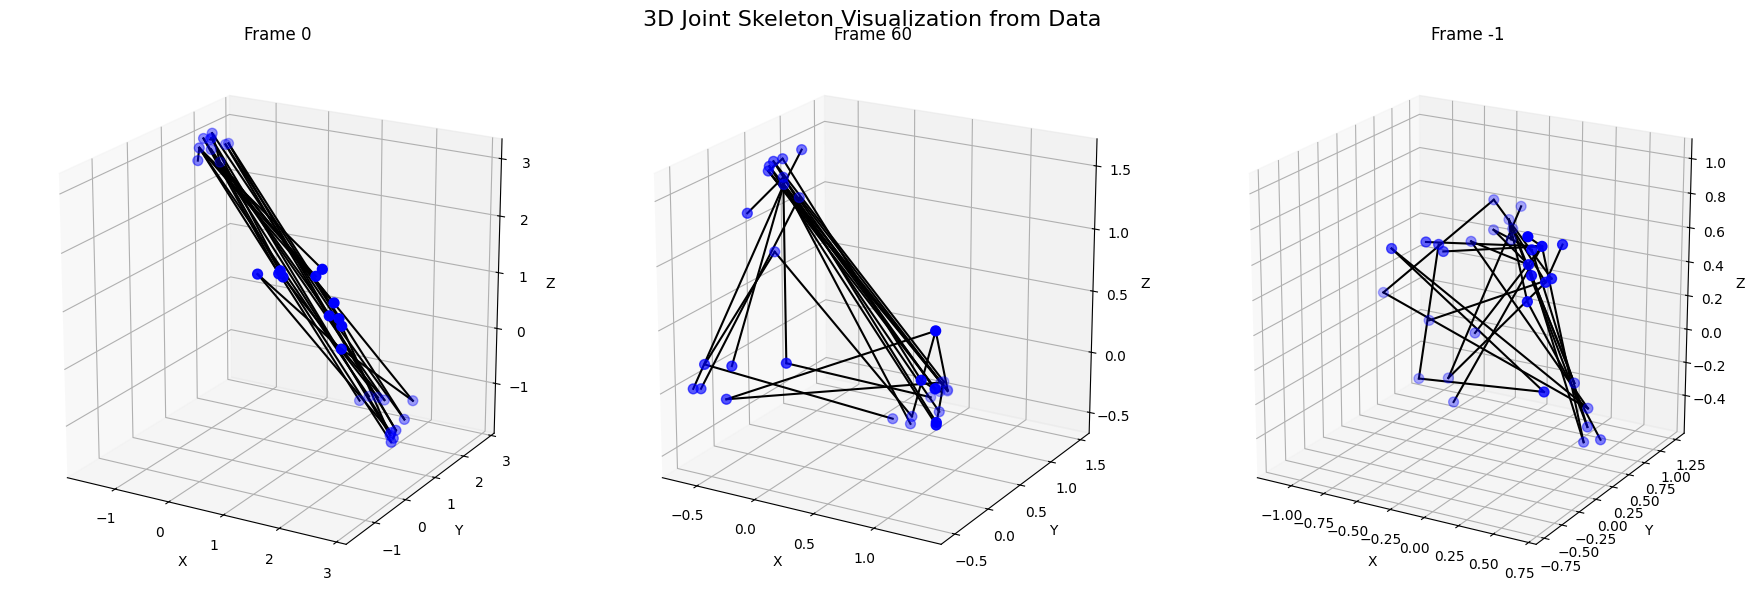

In [3]:
# Re-import necessary modules after kernel reset
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Reload graph structure info
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
         ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}

# Reload dataset
df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.dropna(subset=['QoR_class'], inplace=True)

# Normalize joint columns
joint_cols = [f'{j}_{axis}' for j in joints for axis in ['X', 'Y', 'Z']]
def normalize_joint_data(df):
    scaler = StandardScaler()
    def scale_group(group):
        group[joint_cols] = scaler.fit_transform(group[joint_cols])
        return group
    return df.groupby('patient_id').apply(scale_group).reset_index(drop=True)

df = normalize_joint_data(df)

# Build a visualization sample
window_size = 120
stride = 10
grouped = df.groupby(['patient_id', 'trial'])
samples = []

for (pid, trial), group in grouped:
    group = group.sort_values('t_uniform')
    if len(group) < window_size:
        continue
    for i in range(0, len(group) - window_size + 1, stride):
        window = group.iloc[i:i+window_size]
        x_seq = torch.tensor([
            [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z']] for j in joints]
            for _, row in window.iterrows()
        ], dtype=torch.float)
        samples.append(x_seq)
    break  # only take one patient-trial for plotting

x_seq = samples[0]  # take first example

# Now plot it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

frames_to_plot = [0, len(x_seq)//2, -1]
fig = plt.figure(figsize=(18, 6))

for i, frame_idx in enumerate(frames_to_plot):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    frame = x_seq[frame_idx]
    xs, ys, zs = frame[:, 0].numpy(), frame[:, 1].numpy(), frame[:, 2].numpy()
    ax.scatter(xs, ys, zs, c='blue', s=50)
    for a, b in edges:
        a_idx, b_idx = joint_to_idx[a], joint_to_idx[b]
        ax.plot([xs[a_idx], xs[b_idx]], [ys[a_idx], ys[b_idx]], [zs[a_idx], zs[b_idx]], c='black')
    ax.set_title(f'Frame {frame_idx}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=20, azim=-60)
    ax.set_box_aspect([1,1,1])

plt.suptitle("3D Joint Skeleton Visualization from Data", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Joint list as provided earlier
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

# Anatomically meaningful edges between joints
edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('HEAD', 'NOSE'), ('NOSE', 'EYE_LEFT'), ('NOSE', 'EYE_RIGHT'),
    ('EYE_LEFT', 'EAR_LEFT'), ('EYE_RIGHT', 'EAR_RIGHT'),
    
    ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'), ('SHOULDER_LEFT', 'ELBOW_LEFT'),
    ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'), ('HAND_LEFT', 'HANDTIP_LEFT'),
    ('WRIST_LEFT', 'THUMB_LEFT'),

    ('SPINE_CHEST', 'CLAVICLE_RIGHT'), ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'),
    ('ELBOW_RIGHT', 'WRIST_RIGHT'), ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'),
    ('WRIST_RIGHT', 'THUMB_RIGHT'),

    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'), ('ANKLE_LEFT', 'FOOT_LEFT'),
    ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'), ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT')
]

joint_to_idx = {joint: i for i, joint in enumerate(joints)}

# Simulate one frame of 3D joint data for visualization (real data would come from the dataset)
np.random.seed(0)
frame = np.random.rand(len(joints), 3) * 2 - 1  # dummy joint positions

# Centering the skeleton on the PELVIS
centered_frame = frame - frame[joint_to_idx['PELVIS']]

# Plot with joint names and proper edges
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot joints
xs, ys, zs = centered_frame[:, 0], centered_frame[:, 1], centered_frame[:, 2]
ax.scatter(xs, ys, zs, c='red')

# Plot edges
for a, b in edges:
    ai, bi = joint_to_idx[a], joint_to_idx[b]
    ax.plot([xs[ai], xs[bi]], [ys[ai], ys[bi]], [zs[ai], zs[bi]], 'blue')

# Label joints
for i, joint in enumerate(joints):
    ax.text(xs[i], ys[i], zs[i], joint, fontsize=8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Centered Skeleton with Joint Labels')

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the uploaded dataset
csv_path = path
df = pd.read_csv(csv_path)

# Check columns related to joints
joint_names = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
               'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
               'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
               'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
               'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
               'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

joint_columns = []
for joint in joint_names:
    joint_columns.extend([f'{joint}_X', f'{joint}_Y', f'{joint}_Z'])

# Check if all joint columns are present in the dataset
missing_columns = [col for col in joint_columns if col not in df.columns]

missing_columns[:10]  # Show a few missing columns if any


[]

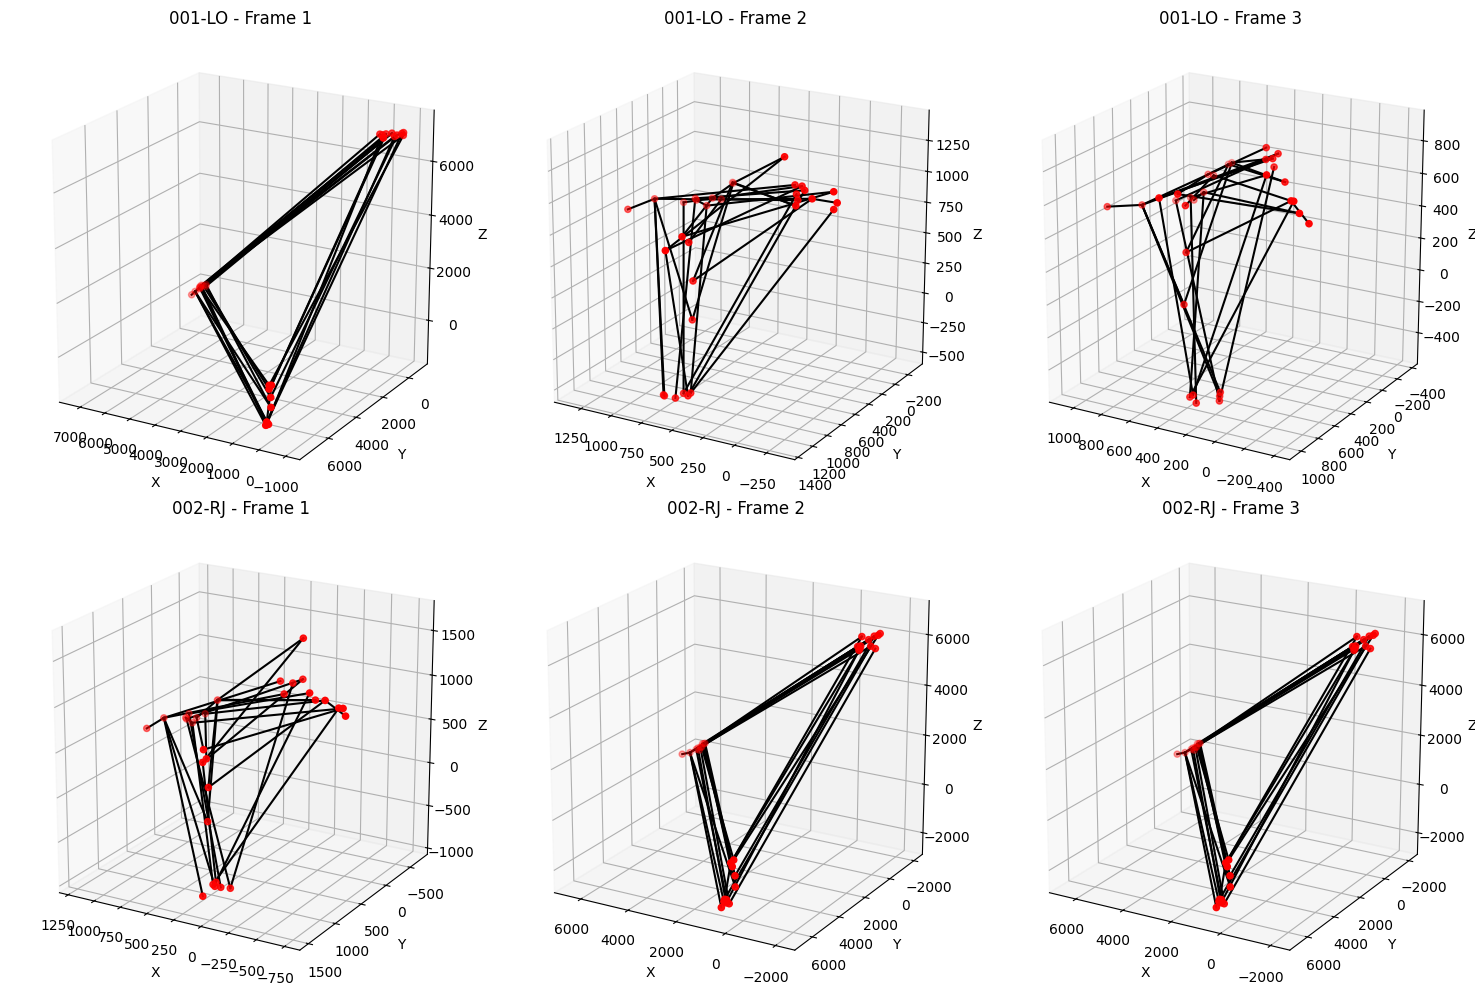

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']  # Filter as in the project

# Joint names
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

# Edges for skeletal connections
edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

# Pick a few unique patients and a few frames
selected_patients = df['patient_id'].unique()[:2]
plot_data = []

for pid in selected_patients:
    trial_frames = df[df['patient_id'] == pid].sort_values('t_uniform').head(3)
    plot_data.append((pid, trial_frames))

# Plotting
fig = plt.figure(figsize=(15, 10))

for i, (pid, frames) in enumerate(plot_data):
    for j, (_, row) in enumerate(frames.iterrows()):
        ax = fig.add_subplot(len(plot_data), 3, i * 3 + j + 1, projection='3d')
        ax.set_title(f"{pid} - Frame {j+1}")
        coords = []
        for joint in joints:
            coords.append([row[f"{joint}_X"], row[f"{joint}_Y"], row[f"{joint}_Z"]])
        coords = pd.DataFrame(coords, columns=['X', 'Y', 'Z'])

        # Draw skeleton
        for a, b in edges:
            idx_a = joints.index(a)
            idx_b = joints.index(b)
            x_vals = [coords.loc[idx_a, 'X'], coords.loc[idx_b, 'X']]
            y_vals = [coords.loc[idx_a, 'Y'], coords.loc[idx_b, 'Y']]
            z_vals = [coords.loc[idx_a, 'Z'], coords.loc[idx_b, 'Z']]
            ax.plot(x_vals, y_vals, z_vals, 'k-')

        ax.scatter(coords['X'], coords['Y'], coords['Z'], c='r', s=20)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=20, azim=120)
        ax.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.show()


In [19]:
# Step 1: Relaxed Cleaning Function
def clean_joint_positions(df, joints, max_val=10):  # Increase max_val to tolerate wider range
    for joint in joints:
        for axis in ['X', 'Y']:
            col = f'{joint}_{axis}'
            df = df[df[col].notna()]            # Remove NaN
            df = df[np.isfinite(df[col])]       # Remove infinite
            df = df[df[col].abs() < max_val]    # Only remove extreme outliers
    return df

# Step 2: Apply with safeguard
df_clean = clean_joint_positions(df.copy(), joints)

# Step 3: Check available patients
unique_patients = df_clean['patient_id'].unique()
print("Remaining Patients:", unique_patients)

# If still empty, abort and print error
if len(unique_patients) == 0:
    raise ValueError("⚠️ No valid patients remain after cleaning. Try increasing max_val or inspecting raw data.")

# Step 4: Proceed safely
selected_pid = unique_patients[0]
print("Selected patient ID:", selected_pid)


Remaining Patients: []


ValueError: ⚠️ No valid patients remain after cleaning. Try increasing max_val or inspecting raw data.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Clean invalid joint values
def clean_joint_positions(df, joints, max_val=5):
    for joint in joints:
        for axis in ['X', 'Y']:
            col = f'{joint}_{axis}'
            df = df[np.isfinite(df[col])]
            df = df[df[col].abs() < max_val]
    return df

# Cleaned dataset
df_clean = clean_joint_positions(df.copy(), joints)

# Select patient
unique_patients = df_clean['patient_id'].unique()
selected_pid = unique_patients[2]
patient_df = df_clean[df_clean['patient_id'] == selected_pid].sort_values('t_uniform')

frames_to_plot = list(range(0, len(patient_df), max(1, len(patient_df) // 6)))[:6]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for i, idx in enumerate(frames_to_plot):
    frame = patient_df.iloc[idx]
    axs[i].set_title(f"Patient: {selected_pid}, Frame: {idx}, t={frame['t_uniform']:.2f}")
    axs[i].invert_yaxis()
    axs[i].set_xlim(-2, 2)
    axs[i].set_ylim(-2, 2)

    for j, joint in enumerate(joints):
        x = frame[f'{joint}_X']
        y = frame[f'{joint}_Y']
        axs[i].scatter(x, y, color='blue')
        axs[i].text(x, y, joint, fontsize=6, ha='center')

    for a, b in edges:
        if all(k in frame for k in [f'{a}_X', f'{a}_Y', f'{b}_X', f'{b}_Y']):
            x1, y1 = frame[f'{a}_X'], frame[f'{a}_Y']
            x2, y2 = frame[f'{b}_X'], frame[f'{b}_Y']
            axs[i].plot([x1, x2], [y1, y2], color='black')

plt.tight_layout()
plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 0

NameError: name 'selected_pid' is not defined

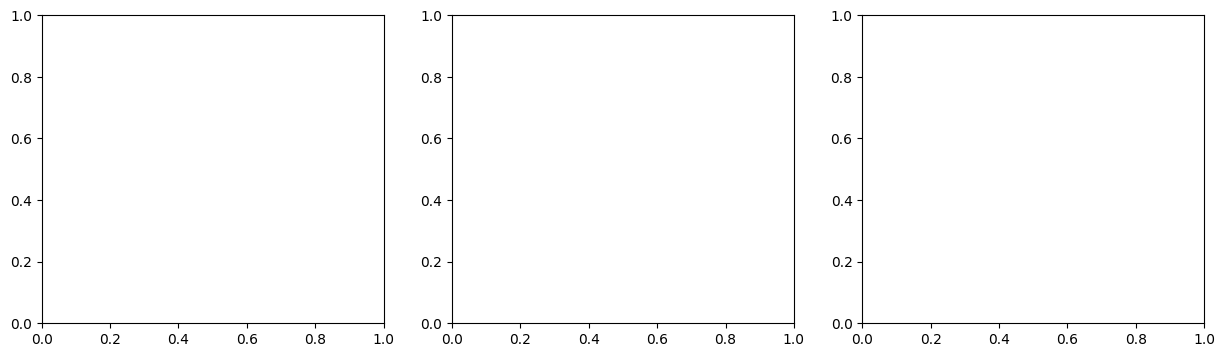

In [ ]:
# As the previous attempt hit memory limits, use fewer frames and smaller figure size
frames_to_plot = list(range(0, len(patient_df), max(1, len(patient_df) // 3)))[:3]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs = axs.flatten()

for i, idx in enumerate(frames_to_plot):
    frame = patient_df.iloc[idx]
    axs[i].set_title(f'Patient: {selected_pid}, Frame: {idx}')
    axs[i].invert_yaxis()
    axs[i].set_xlim(-1.5, 1.5)
    axs[i].set_ylim(-1.5, 1.5)

    # Plot joints
    for joint in joints:
        x = frame[f'{joint}_X']
        y = frame[f'{joint}_Y']
        axs[i].scatter(x, y, color='blue', s=10)
        axs[i].text(x, y, joint.split('_')[0], fontsize=5, ha='center')

    # Plot edges
    for a, b in edges:
        x1, y1 = frame[f'{a}_X'], frame[f'{a}_Y']
        x2, y2 = frame[f'{b}_X'], frame[f'{b}_Y']
        axs[i].plot([x1, x2], [y1, y2], color='black', linewidth=1)

plt.tight_layout()
plt.show()
